## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models 
from torch.utils.data import DataLoader
import os
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

2024-04-19 18:58:09.607822: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 18:58:10.313339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#UNCOMMENT IF NEEDED------------------------------------------------------------------------------------------------------
# #Download Dataset
# import opendatasets as od

# od.download("https://www.kaggle.com/datasets/aysendegerli/qatacov19-dataset/data")

## Training With LoRA

In [3]:
#!/usr/bin/python                                                  
from PIL import Image                                              
import os, sys                       

train_img_path = "/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/Dataset/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Images/*.png"
test_img_path = "/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/Dataset/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/*.png"

train_mask_path = "/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/Dataset/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths/*.png"
test_mask_path = "/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/Dataset/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/*.png"

### Import Images and Create Dataset

In [4]:
from skimage import io

# Load all images in the current folder that end with .png
train_img = io.imread_collection(train_img_path)
test_img = io.imread_collection(test_img_path)
train_mask = io.imread_collection(train_mask_path)
test_mask = io.imread_collection(test_mask_path)

In [5]:
from skimage.transform import resize

def resize_images(images, mask):
    output = []
    if mask:
        for mask in images:
            # Perform resizing with nearest neighbor interpolation to maintain binary values
            resized_mask = (resize(mask, (256, 256), order=0, anti_aliasing=False) > 0.5).astype(np.uint8)
            output.append(resized_mask)
    else:
        for image in images:
            resized_image = resize(image, (256, 256), anti_aliasing=False)
            output.append(resized_image)
    
    return output

# Resize training images to 256x256
train_img = resize_images(train_img, False)

# Resize testing images to 256x256
test_img = resize_images(test_img, False)

# Resize training masks to 256x256
train_mask = resize_images(train_mask, True)

# Resize testing masks to 256x256
test_mask = resize_images(test_mask, True)

#Convert to np array
train_img = np.array(train_img)
test_img = np.array(test_img)
train_mask = np.array(train_mask)
test_mask = np.array(test_mask)

In [6]:
#Print Shape of resized images
print("Shape of resized training raw image: " + str(train_img.shape))
print("Shape of resized testing raw image: " + str(test_img.shape))
print("Shape of resized training mask image: " + str(train_mask.shape))
print("Shape of resized testing mask image: " + str(test_mask.shape))

Shape of resized training raw image: (7145, 256, 256)
Shape of resized testing raw image: (2113, 256, 256)
Shape of resized training mask image: (7145, 256, 256)
Shape of resized testing mask image: (2113, 256, 256)


In [7]:
#Combine images and masks respectively
images = np.concatenate((train_img, test_img))
masks = np.concatenate((train_mask, test_mask))

print("Shape of resized images: " + str(images.shape))
print("Shape of resized masks: " + str(masks.shape))


Shape of resized images: (9258, 256, 256)
Shape of resized masks: (9258, 256, 256)


In [8]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images],
    "mask": [Image.fromarray(mask) for mask in masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [9]:
#Check dataset info
print("Dataset Info:\n" + str(dataset))

Dataset Info:
Dataset({
    features: ['image', 'mask'],
    num_rows: 9258
})


In [10]:
# #Split dataset into train/test
# ds = dataset.train_test_split(test_size=0.1)
# train_ds = ds["train"]
# test_ds = ds["test"]

### Get Bounding Boxes

In [11]:
#Function that gets bounding boxes from masks
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  #add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

### Visualize stuff (Sanity Check)

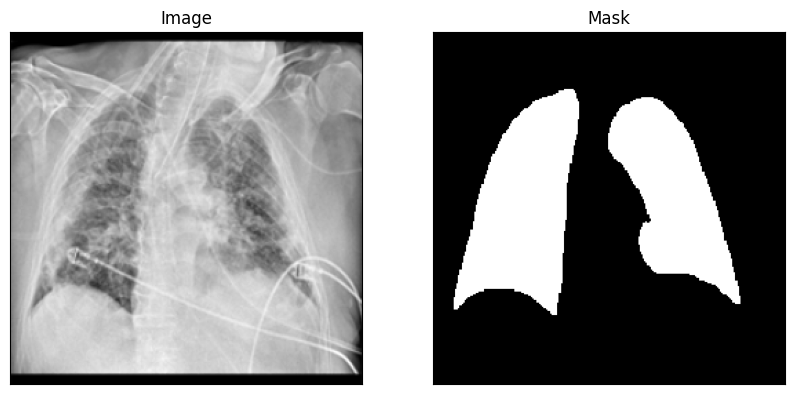

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import random

#Get random image from training set and plot
img_num = random.randint(0, 9000)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["mask"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

### LoRA Config

In [13]:
from segment_anything import build_sam, SamPredictor
from segment_anything import sam_model_registry

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn.parameter import Parameter
from segment_anything.modeling import Sam
from safetensors import safe_open
from safetensors.torch import save_file


class _LoRA_qkv(nn.Module):
    """In Sam it is implemented as
    self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv.unbind(0)
    """

    def __init__(
        self,
        qkv: nn.Module,
        linear_a_q: nn.Module,
        linear_b_q: nn.Module,
        linear_a_v: nn.Module,
        linear_b_v: nn.Module,
    ):
        super().__init__()
        self.qkv = qkv
        self.linear_a_q = linear_a_q
        self.linear_b_q = linear_b_q
        self.linear_a_v = linear_a_v
        self.linear_b_v = linear_b_v
        self.dim = qkv.in_features
        self.w_identity = torch.eye(qkv.in_features)

    def forward(self, x):
        qkv = self.qkv(x)  # B,N,N,3*org_C
        new_q = self.linear_b_q(self.linear_a_q(x))
        new_v = self.linear_b_v(self.linear_a_v(x))
        qkv[:, :, :, : self.dim] += new_q
        qkv[:, :, :, -self.dim :] += new_v
        return qkv

class LoRA_Sam(nn.Module):
    """Applies low-rank adaptation to a Sam model's image encoder.

    Args:
        sam_model: a vision transformer model, see base_vit.py
        r: rank of LoRA
        num_classes: how many classes the model output, default to the vit model
        lora_layer: which layer we apply LoRA.

    Examples::
        >>> model = ViT('B_16_imagenet1k')
        >>> lora_model = LoRA_ViT(model, r=4)
        >>> preds = lora_model(img)
        >>> print(preds.shape)
        torch.Size([1, 1000])
    """

    def __init__(self, sam_model: Sam, r: int, lora_layer=None):
        super(LoRA_Sam, self).__init__()

        assert r > 0
        
        if lora_layer:
            self.lora_layer = lora_layer
        else:
            self.lora_layer = list(range(len(sam_model.vision_encoder.layers)))
        # create for storage, then we can init them or load weights
        self.w_As = []  # These are linear layers
        self.w_Bs = []

        # lets freeze first
        for param in sam_model.vision_encoder.layers.parameters():
            param.requires_grad = False

        # Here, we do the surgery
        for t_layer_i, blk in enumerate(sam_model.vision_encoder.layers):
            # If we only want few lora layer instead of all
            if t_layer_i not in self.lora_layer:
                continue
            w_qkv_linear = blk.attn.qkv
            self.dim = w_qkv_linear.in_features
            w_a_linear_q = nn.Linear(self.dim, r, bias=False)
            w_b_linear_q = nn.Linear(r, self.dim, bias=False)
            w_a_linear_v = nn.Linear(self.dim, r, bias=False)
            w_b_linear_v = nn.Linear(r, self.dim, bias=False)
            self.w_As.append(w_a_linear_q)
            self.w_Bs.append(w_b_linear_q)
            self.w_As.append(w_a_linear_v)
            self.w_Bs.append(w_b_linear_v)
            blk.attn.qkv = _LoRA_qkv(
                w_qkv_linear,
                w_a_linear_q,
                w_b_linear_q,
                w_a_linear_v,
                w_b_linear_v,
            )
        self.reset_parameters()
        self.sam = sam_model

    def load_fc_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.
        """

        assert filename.endswith(".safetensors")
        _in = self.lora_vit.head.in_features
        _out = self.lora_vit.head.out_features
        with safe_open(filename, framework="pt") as f:
            saved_key = f"fc_{_in}in_{_out}out"
            try:
                saved_tensor = f.get_tensor(saved_key)
                self.lora_vit.head.weight = Parameter(saved_tensor)
            except ValueError:
                print("this fc weight is not for this model")

    def save_lora_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.
        
        save both lora and fc parameters.
        """

        assert filename.endswith(".safetensors")

        num_layer = len(self.w_As)  # actually, it is half
        a_tensors = {f"w_a_{i:03d}": self.w_As[i].weight for i in range(num_layer)}
        b_tensors = {f"w_b_{i:03d}": self.w_Bs[i].weight for i in range(num_layer)}
        
        merged_dict = {**a_tensors, **b_tensors}
        save_file(merged_dict, filename)

    def load_lora_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.\
            
        load both lora and fc parameters.
        """

        assert filename.endswith(".safetensors")

        with safe_open(filename, framework="pt") as f:
            for i, w_A_linear in enumerate(self.w_As):
                saved_key = f"w_a_{i:03d}"
                saved_tensor = f.get_tensor(saved_key)
                w_A_linear.weight = Parameter(saved_tensor)

            for i, w_B_linear in enumerate(self.w_Bs):
                saved_key = f"w_b_{i:03d}"
                saved_tensor = f.get_tensor(saved_key)
                w_B_linear.weight = Parameter(saved_tensor)
                
    def reset_parameters(self) -> None:
        for w_A in self.w_As:
            nn.init.kaiming_uniform_(w_A.weight, a=math.sqrt(5))
        for w_B in self.w_Bs:
            nn.init.zeros_(w_B.weight)

### SAM Processor

In [14]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["mask"])

    image = np.array(image.convert("RGB"))

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
    
    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    
    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

### Train Model

In [15]:
# Load SAM model
from transformers import SamModel
sam = SamModel.from_pretrained("facebook/sam-vit-base")

rank = 512
LoRA_sam = LoRA_Sam(sam, rank)
model = LoRA_sam.sam

# make sure we only compute gradients for vision encoder
for name, param in model.named_parameters():
  if name.startswith("mask_decoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [16]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

#Process data
train_dataset = SAMDataset(dataset=dataset, processor=processor)

# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [17]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.vision_encoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [18]:
from tqdm import tqdm
from statistics import mean
import torch
import torch.nn as nn
from torch.nn.parallel import DataParallel
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 6

# Move your model to GPU devices
##########################device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:2")
model = model.to(device)

model.train()

for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 8/4629 [00:07<1:11:04,  1.08it/s]


KeyboardInterrupt: 

In [ ]:
# Save the model's state dictionary to a file
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mean(epoch_losses),
            }, f"/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/LoRA_SAM/LoRA_sam_model_checkpoint_rank{rank}.pth")

# Save the parameters of the model in safetensors format
LoRA_sam.save_lora_parameters(f"/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/LoRA_SAM/lora_rank{rank}.safetensors")

### Inference

In [20]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [22]:
# Load SAM model
from transformers import SamModel

SAM = SamModel.from_pretrained("facebook/sam-vit-base")
LoRA_pred = LoRA_Sam(SAM, rank)

LoRA_pred.load_lora_parameters(f"/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/LoRA_SAM/lora_rank{rank}.safetensors") 
lora_model = LoRA_pred.sam

state_dict = torch.load(f"/home/cahsi/Josh/Research/venv/Semantic_Segmentation_Research/LoRA_SAM/LoRA_sam_model_checkpoint_rank{rank}.pth")
state_dict = state_dict['model_state_dict']
lora_model.load_state_dict(state_dict)

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [23]:
# set the device to cuda if available, otherwise use cpu
device = "cuda:1" if torch.cuda.is_available() else "cpu"
lora_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): _LoRA_qkv(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (linear_a_q): Linear(in_features=768, out_features=512, bias=False)
            (linear_b_q): Linear(in_features=512, out_features=768, bias=False)
            (linear_a_v): Linear(in_features=768, out_features=512, bias=False)
            (linear_b_v): Linear(in_features=512, out_features=768, bias=False)
          )
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): 

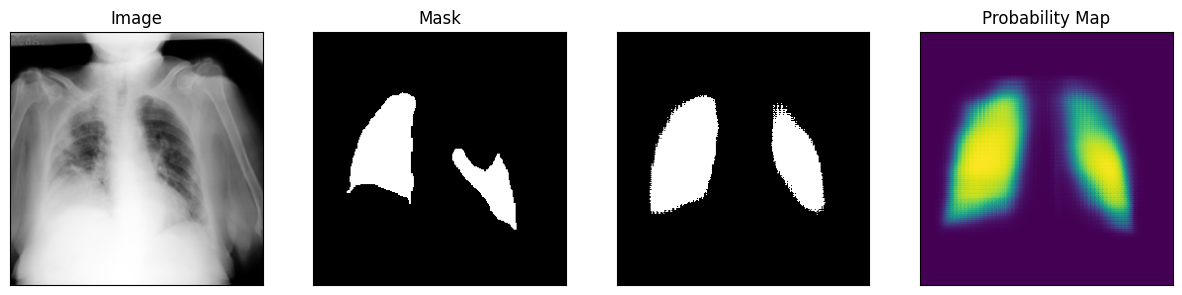

In [27]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]
test_image = np.array(test_image.convert("RGB"))

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["mask"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

lora_model.eval()

# forward pass
with torch.no_grad():
    outputs = lora_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.6).astype(np.uint8)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
test_image = dataset[idx]["image"]
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the mask on the middle left
test_image = dataset[idx]["mask"]
axes[1].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[1].set_title("Actual Mask")


# Plot the second image on the middle right
axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[3].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[3].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

https://github.com/MathieuNlp/Sam_LoRA?tab=readme-ov-file